# **Simulazioni kinetic Monte Carlo con il modulo CMS**

### Introduzione: perché la kinetic Monte Carlo?

MD simulazioni processi di superficie, adatom passa molto tempo vibrando attorno posizioni equilibrio, non rilevante, ci interessano le diffusioni. 

Che fare? o incentivi molto le diffusioni nelle sim MD, oppure le rimuovi e segui una dinamica stocastica tra configurazioni. Seconda opzione possibile perché c'è netta **separazione tra** le due **scale temporali**. Costruisco una griglia, ogni luogo della griglia $x_i$ è un _bacino_ del profilo di energia potenziale.

Le vibrazioni sono nell'ordine di $\nu\simeq10^{12}-10^{13}\text{ Hz}$, quindi tempo caratteristico $\tau\simeq0.1-1\text{ ps}$ mentre, come visto anche nel [tutorial](../MolecularDynamics/5-io.ipynb) sulle classi writer di `CMS.MolecularDynamics`, le diffusioni sono nell'ordine delle decine o addirittura centinaia di picosecondi ($\tau_\text{diff}\simeq0.1\text{ ns}$), anche a  

<img src="../images/KineticMonteCarlo/from-md-to-stochastic.png" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: auto; width: 500px;">

---

## Teoria: come funziona la KMC?

### Ipotesi 1) termalizzazione dopo ogni salto: processo markoviano

Atomo vibra sul posto, poi ogni tanto salta da un sito ad un altro. Se:
- salti non correlati
- distribuzione di boltzmann realizzata ad ogni passaggio

allora: **processo markoviano**, lo stato attuale dipende soltanto dal precedente.

### Ipotesi 2) processo markoviano tempo-omogeneo


$$dP(x_j,t+dt|x_i,t) \approx k_{ji}(t) dt$$

probabilità di transizione per unità di tempo (rate insomma) da stato $x_i$ a stato $x_j$ è $k_{ij}$, quindi si può formare la matrice $k$ dimensione $N\times N$. l'ipotesi qui è che questi rate siano costanti e non dipendano dalle condizioni del sistema.

$$ 
k_{ij}(t) = k_{ij} = cost
$$

### Ipotesi 3) ergodicità

tutte le configurazioni possono essere raggiunte da uno stato iniziale dopo un numero finito sufficiente di transizioni. 

### **Master equation**: $gain - loss$

probabilità di essere in $j$ dopo tempo $t$ essendo partiti da $i$
- probabilità di passaggio (_gain_) da $i$ a qualsiasi $l$ intermedio che poi mi porta in $j$
- meno la probabilità (_loss_) che da $j$ si vada in altro $i$

$$
\frac{dP}{dt} (x_j,t|x_i) = \sum_{l \neq i} k_{jl} P(x_l,t|x_i) - k_{jl} P(x_j,t|x_i)
$$

### Stato stazionario

Dopo molto di tempo si raggiunge uno stato stazionario (= di equilibrio) in cui:
$$
t \to \infty:   P(x_j,t | x_i) = P^{eq}(x_j)
$$

**steady-state master equation**\
stazionario -> derivata temporale nulla.
pongo uguale a zero il flusso netto tra le singole coppie: **bilancio dettagliato**. sufficiente ma non necessario, imposizione forte! perché basterebbe che complessivamente tutte le somme facessero zero
$$
\frac{dP}{dt} (x_j,t|x_i) = \sum_{l \neq i} k_{jl} P^{eq}(x_l) - k_{jl} P^{eq}(x_j) = 0
$$

**detailed balance**

$$k_{jl} P^{eq}(x_l) = k_{jl} P^{eq}(x_j)$$

If we evolve the Markov chain using transition rates that fullfil detailed balance we directly sample the stationary state

### Transition state theory: come definire i rate?

I rate della **harmonic transition rate theory** seguono la legge di Arrhenius e soddisfano il **detailed balance**:
$$
k_{HTST} = \nu e^\frac{-E_b}{k_B T}
$$

<img src="../images/6-KineticMonteCarlo/htst-rates-detailed-balance.png" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: auto; width: 500px;">

### Come applicarlo? Algoritmo di Bortz-Kalos-Lebowitz

L'energia di ogni atomo è dovuta ai legami che forma. Nel modello _SOS_ (solid-on-solid), in cui consideriamo soltanto gli atomi in cima, $4$ con il substrato e $n^{(1)}\in\{0,\dots,4\}$ con le celle laterali. Ogni singolo legame contribuisce con un'energia $J_1$.
$$
\varepsilon_k = J_0 + n^{(1)}_{k} J_1
$$
dove $J_0=4J_1$.

Calcolo ciascun rate $\{k_{ij}\}_{ij}$ e la loro somma $k_\text{tot}$. Estraggo un numero casuale $\rho\in[0,k_\text{tot})$ e seleziono gli indici dell'evento da eseguire $j \to i$ in modo che:
$$
\sum_{p=1}^{i} \sum_{q=1}^{j-1} k_{ij} < \rho < \sum_{p=1}^{i} \sum_{q=1}^{j} k_{ij}
$$

Il _time-step_ non è costante, ma un _random escape time_. Si estrae con distribuzione uniforme $\xi\in[0,1)$ e poi si deriva il tempo tra un evento e l'altro dalla distribuzione espoenziale della statistica poissoniana:
$$
\tau = -\frac{\ln(\xi)}{k} 
\quad
\text{segue:}
\quad
p(\tau) = ke^{-k\tau}
$$

### E la deposizione?

Si consideri una gliglia di $L_x \times L_y$ siti e si assuma che in ogni sito la probabilità di deposizione sia la medesima. Se $k_\text{depo}$ indica il rate di deposizioni dell'esperimento, si potrà scrivere:
$$
k_\text{depo} = \phi L_x L_y
$$
in poche parole, il rate complessivo di eventi di deposizione è la somma di tutti i singoli rate. In questo modo si può eliminare la necessità di considerare un rate diverso per ciascun sito. $\phi$ sarà chiamato **flusso** e si misura in [ML/s] _monolayers per second_.

---

## Costruire un oggetto `KineticMonteCarlo`

L'oggetto [`KineticMonteCarlo`](../../CMS/MonteCarlo/KineticMonteCarlo.py) di `CMS` contiene la logica dell'algoritmo _kinetic Monte Carlo_. Per essere istanzato, richiede i parametri visti nell'introduzione teorica:


<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`flux`** | float | / | Flusso di deposizioni in [ML/s] |
| **`L`** | tuple[int, int] | / | Dimensioni x,y della griglia da simulare |
| **`T`** | float | / | Temperatura in kelvin della simulazione |
| **`nu`** | float | 1E+13 | Frequenza delle vibrazioni attorno a un minimo dell'energia |
| **`J0`** | float | 4 * `J1` | Energia di legame tra un atomo e il substrato |
| **`J1`** | float | -0.345 | Singola energia di legame in una coppia di vicini |

</div>

Supponiamo di voler simulare inizialmente una dinamica **stick-where-you-hit**, in cui gli atomi depositati rimangono nel sito in cui sono posti inizialmente. Per farlo, basterà porre la temperatura a $0 \text{ K}$. Prendiamo, in modo del tutto arbitrario, un flusso di 0.2 ML/s su una griglia 50x50 e decidiamo di depositare 3 layer. A questo scopo, saranno necessari 3/0.2 = 15 secondi.

In [1]:
from CMS.MonteCarlo.KineticMonteCarlo import KineticMonteCarlo

flusso = 0.2
L = (50, 50)
temperatura = 0

simulazione = KineticMonteCarlo(
    flux=flusso,
    L=L,
    T=temperatura
)

Una volta istanziato l'oggetto, l'algoritmo può essere avviato chiamando il metodo `.run()`, che restituirà i risultati raggruppati in un `KineticMonteCarloResult`.

<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`end_time`** | float | / | Tempo totale da simulare in secondi |

</div>

In [2]:
# simuliamo 
result = simulazione.run(end_time=15)

---

## Esempio di analisi

Un oggetto `KineticMonteCarloResult` contiene diversi dati riguardanti la simulazione appena svolta. Gli attributi `.dt_list` e `.rms_roughness_list` contengono rispettivamente gli intervalli di tempo tra ogni evento di deposizione e la rugosità della superficie aggiornata ad ogni evento di deposizione. In questo specifico caso non sono state incluse le diffusioni nella simulazione ($T=0$), pertanto `.dt_list` conterrà esattamente i valori di $\tau$ di _random escape time_. Andiamo allora a vedere se i $\tau$ osservati ricostruiscono la distribuzione esponenziale. Successivamente verifichiamo che, nel modello **stick-where-you-hit**, la _roughness_ cresce con un'andamento simile all'errore poissoniano, ovvero come una radice quadrata.

> 💡 Una simulazione _stick-where-you-hit_ è poissoniana proprio come il famoso esempio dei bombordamenti a Londra durante la Seconda Guerra Mondiale!

#### Distribuzione dei $\tau$

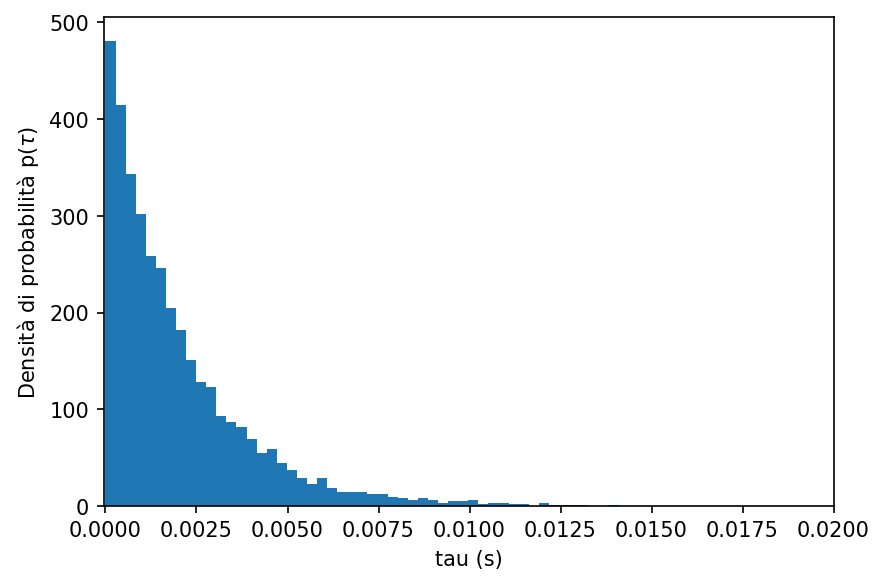

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = result.dt_list # T=0, ergo dt coincide con tau perché ho solo eventi di deposizione
n = len(x)
n_bins = round(np.sqrt(n))

# plot #
plt.figure(figsize=(6,4), dpi=150)
# istogramma NORMALIZZATO (con density=True diventa una pdf)
y, bins, _ =plt.hist(x, bins=n_bins, density=True)

plt.xlabel('tau (s)')
plt.ylabel('Densità di probabilità p($\\tau$)')
plt.xlim(-0.00005, 0.02)
#plt.ylim(0, 700)
plt.tight_layout()
plt.show()

La distribuzione dei $\tau$ sembra essere esponenziale. Un altro modo per verificare che l'algoritmo stia funzionando correttamente è confrontare la media campionaria degli intervalli di tempo $\bar\tau$ con $1/k_\text{depo}$. Notare che, poiché $T=0$, $k_\text{tot} = cost = k_\text{depo}$ ergo abbiamo un processo di Poisson omogeneo.

In [4]:
# media campionaria dei tau
media_campionaria = np.mean(result.dt_list)
# valore di aspettazione della distribuzione esponenziale
valore_medio = 1/(flusso*L[0]*L[1])

print(r'$\bar\tau$ =', media_campionaria)
print(r'$\langle\tau\rangle$ =', valore_medio)

$\bar\tau$ = 0.002006927449103205
$\langle\tau\rangle$ = 0.002


#### Roughness $\sigma$

$\sigma(t) \propto \sqrt{t}$ è la firma inequivocabile del processo poissoniano in atto. Nel regime **stick-where-you-hit** ($T=0$) ogni cella è un sistema isolato, perciò le deposizioni in una posizione non influenzano le altre regioni.

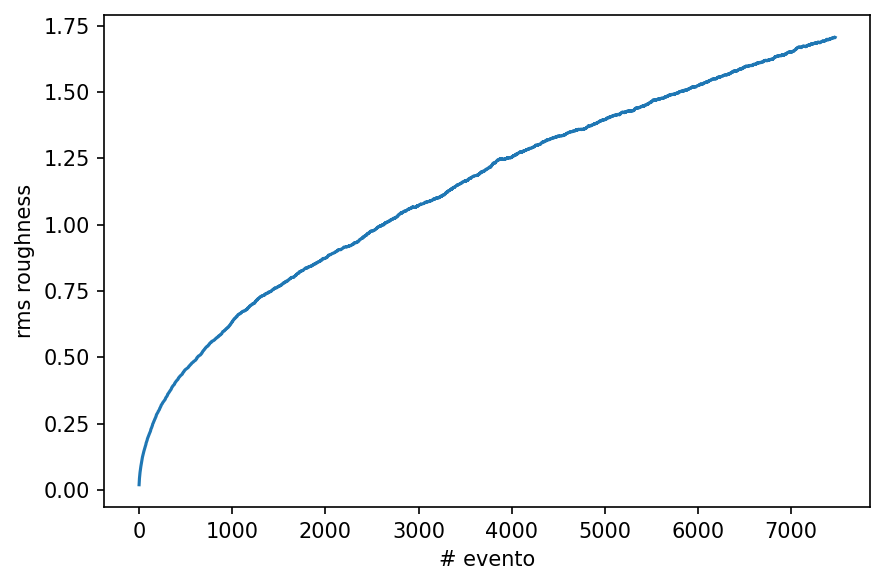

In [5]:
x = np.arange(len(result.rms_roughness_list))
y = result.rms_roughness_list

plt.figure(figsize=(6,4), dpi=150)

plt.plot(x, y)

plt.xlabel('# evento')
plt.ylabel('rms roughness')
plt.tight_layout()
plt.show()